In [25]:
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tfc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from modeling import finetune_classifier

from modeling import stacking_from_csv
import pickle
from src import InputPipeline, make_finetune_curves

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check GPU for tf

In [3]:
# Some GPU setup
# for documentation about using gpus refer to: https://www.tensorflow.org/install/pip#windows-wsl2

tf.keras.backend.clear_session()

device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
try:  # prevent a previous session from being alive
  sess.close() 
except:
  pass

tfc.enable_eager_execution()
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.80)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

### Optional Stuff
- Here we compute classweights since the data is very imbalanced

In [4]:
train_df = pd.read_csv("../data/train_images_stratified.csv")

In [5]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = train_df["label"].unique(), y=train_df["label"])
class_weights = dict(enumerate(class_weights))

## Configure Parameters

In [35]:
INPUT_SHAPE = (220, 220,3)

CONF = {
  "learning_rate": 0.00001,
  "batch_size": 16,
  "epochs": 5,
  "loss_function": "sparse_categorical_crossentropy",
  "metric": "sparse_categorical_accuracy",
}

## Make Input Pipelines

In [36]:
# Input pipeline for subspecies
sub_species_input_pipeline = InputPipeline(splits=(0.8,0.0,0.2), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
# This has a stratified split
sub_species_input_pipeline.make_stratified_train_dataset(
  train_ds_path= "../data/train_ds_images_stratified.csv",
  val_ds_path="../data/val_ds_images_stratified.csv",
)


# Input pipeline for species
species_input_pipeline = InputPipeline(splits=(0.85,0.0,0.15), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
species_input_pipeline.make_train_datasets(directory="../data/train_images/species_classify")  # This doesnt have a stratified split


Datasets populated!
Found 15704 files belonging to 70 classes.
Using 13349 files for training.
Using 2355 files for validation.
Datasets populated!


In [37]:
callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
callback_LR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10)

# Finetuning our models
## Species

In [38]:
finetune_classifier(
    model_path="../classifiers/tuning_test",
    configuration=CONF,
    train_dataset=sub_species_input_pipeline.train_dataset,
    validation_dataset=sub_species_input_pipeline.validation_dataset,
    class_weights=class_weights
                    )

Folder '../classifiers/' already exists.
Folder '../classifiers/trainHistoryDict' already exists.
Epoch 1/5
774/774 [==============================] - 185s 214ms/step - loss: 11.4963 - sparse_categorical_accuracy: 0.0717 - val_loss: 9.3299 - val_sparse_categorical_accuracy: 0.2223 - lr: 1.0000e-05
Epoch 2/5
774/774 [==============================] - 160s 207ms/step - loss: 10.8201 - sparse_categorical_accuracy: 0.1249 - val_loss: 8.9880 - val_sparse_categorical_accuracy: 0.2708 - lr: 1.0000e-05
Epoch 3/5
774/774 [==============================] - 168s 217ms/step - loss: 10.2705 - sparse_categorical_accuracy: 0.1591 - val_loss: 8.6751 - val_sparse_categorical_accuracy: 0.2992 - lr: 1.0000e-05
Epoch 4/5
774/774 [==============================] - 175s 226ms/step - loss: 9.7955 - sparse_categorical_accuracy: 0.1960 - val_loss: 8.3749 - val_sparse_categorical_accuracy: 0.3257 - lr: 1.0000e-05
Epoch 5/5
774/774 [==============================] - 207s 267ms/step - loss: 9.4277 - sparse_catego

INFO:tensorflow:Assets written to: ../classifiers/tuning_test_tuned\assets


INFO:tensorflow:Assets written to: ../classifiers/tuning_test_tuned\assets


Model saved the tuned model under: ../classifiers/tuning_test_tuned


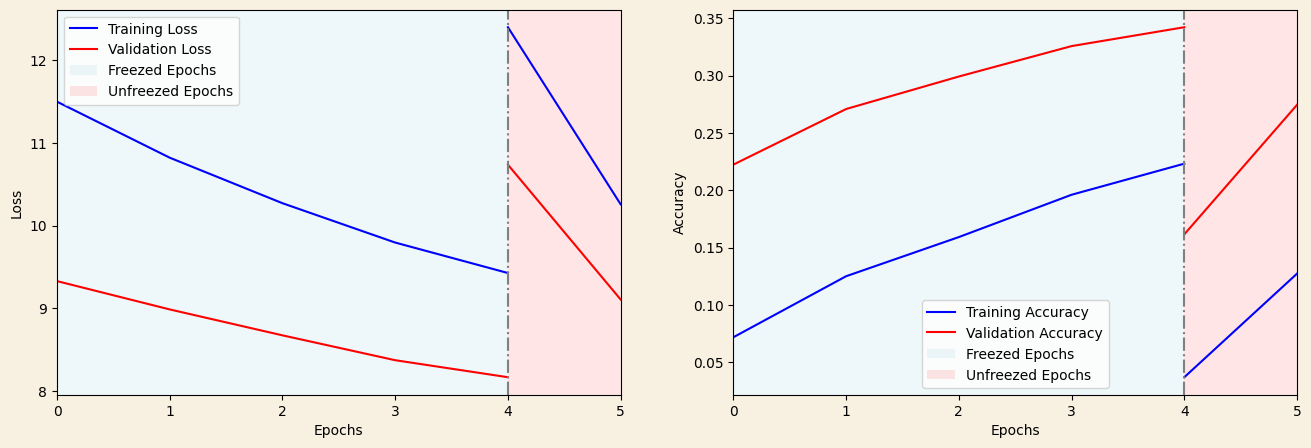

In [40]:
with open("../classifiers/trainHistoryDict/tuning_test.pkl", "rb") as file:
    primary_hist = pickle.load(file)
with open("../classifiers/trainHistoryDict/tuning_test_tuned.pkl", "rb") as file:
    secondary_hist = pickle.load(file)

make_finetune_curves(primary_hist, secondary_hist)

## Family Classifier

In [90]:
finetune_classifier(
    model_path="../classifiers/tuning_test",
    configuration=CONF,
    train_dataset=sub_species_input_pipeline.train_dataset,
    validation_dataset=sub_species_input_pipeline.validation_dataset,
    class_weights=class_weights
                    )